Copyright 2024 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

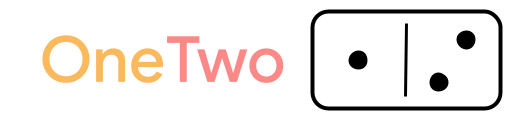

This colab illustrates how to use the [OneTwo](https://github.com/google-deepmind/onetwo) library.

# Installation

In [ ]:
# Install OneTwo
#!pip install git+https://github.com/google-deepmind/onetwo

# Overview

One of the key principles behind the OneTwo library is to enable the creation of complex flows involving several calls to foundation models and possibly other tools.
For ease of experimentation, it is important to easily change the backends or their configuration and run the same flow on two backends/configurations, e.g. when doing comparisons.

The bottleneck is often the multiple RPC requests that need to happen. This makes fast iterations or experimenting on many examples slow and tedious. In order to reduce this bottleneck, there are two strategies that are implemented in the OneTwo library:
1. **Caching**: The result of the calls to the models are cached, which enables one to very quickly replay a flow or an experiment which may have partially executed (e.g. failed in the middle of execution). For example, if you have a complex flow and want to add just one extra step, rerunning the whole thing amounts to reading everything from cache and only executing for real that one last step.
1. **Asynchronous Execution**: While some of the model calls might need to be chained serially, there are many situations when you may want to execute some calls in parallel (e.g. talking to different backends, running an experiment on many examples, or having a step in your flow where several independent tasks are performed). A natural way to do that is to use asynchronous programming, or multi-threading.

In this section, we provide an introduction that illustrates how to connect to and prompt a model using the basic OneTwo functionality.

## Connecting to a Model

The OpenAI and Gemini APIs provide an easy way to connect to a model. Select your preferred API in the drop-down and enter the corresponding API key in the text box below.

OneTwo also supports conncting to other models such as Gemma models running locally or on a server. See Appendix A for details.

In [ ]:
# @title Backend Selection {run:"auto"}
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

# Model Selection Dropdown
model_selection = 'Gemini API' # @param [ 'Gemini API', 'OpenAI API']

# Boilerplate for conditional cell execution
@register_cell_magic('run_if')
def run_if(line, cell):
  if eval(line):
     get_ipython().run_cell(cell)
  else:
    pass

### Gemini API

OneTwo can connect to Gemini models via the Gemini API. If you have not used the Gemini API before, you will need to first create an account and API key following the instructions on https://ai.google.dev/. Then either copy-paste your API key into the text box, or store it in the 'GOOGLE_API_KEY' environment variable.

In [ ]:
%%run_if model_selection == 'Gemini API'  # Execute cell only for 'Gemini API'

import os
from onetwo.backends import gemini_api

# You can specify your API key either here or as an environment variable.
api_key = None  # @param {type: 'string'}

if not api_key and 'GOOGLE_API_KEY' not in os.environ:
  raise ValueError(
      'The api key must be specified either here or in the environment.')

# Create and register a connection to the default Gemini backend (Gemini Pro).
backend = gemini_api.GeminiAPI(api_key=api_key, temperature=0.0)
backend.register()
print('Gemini API backend registered.')

### OpenAI API

OneTwo can connect to OpenAI models via the OpenAI API. If you have not used the OpenAI API before, you will need to first create an account and API key at https://platform.openai.com/signup. Then copy-paste your API key into the text box below.

In [ ]:
%%run_if model_selection == 'OpenAI API'  # Execute cell only for 'OpenAI API'

import os
from onetwo.backends import openai_api

# You can specify your API key either here or as an environment variable.
api_key = None  # @param {type: 'string'}

if not api_key and 'OPENAI_API_KEY' not in os.environ:
  raise ValueError(
      'The api key must be specified either here or in the environment.')

# Create and register a connection to the default Gemini backend (Gemini Pro).
backend = openai_api.OpenAIAPI(
    api_key=api_key,
    model_name='gpt-3.5-turbo',  # Specify the model of your choice.
    temperature=0.0)
backend.register()
print('OpenAI API backend registered.')

### Saving and Loading Caches

When creating a backend, one can associate a cache file to it, which allows one to store and retrieve previously executed requests.

In [ ]:
# Use different filenames for Gemini API and OpenAI API.
if model_selection == 'Gemini API':
  creator = gemini_api.GeminiAPI
  cache_filename = '/tmp/gemini_cache.txt'
else:
  creator = openai_api.OpenAIAPI
  cache_filename = '/tmp/openai_cache.txt'

When creating the backend, we can associate a cache file using the parameter `cache_filename`. This initializes the cache if the file exists.

In [ ]:
import os

# Create the backend that we selected above and provide a cache filename.
backend = creator(
    api_key=api_key,
    temperature=0.0,
    cache_filename=cache_filename,
)
backend.register()

if os.path.isfile(cache_filename):
  print(f'Loading cache from {cache_filename}')
  backend.load_cache()
else:
  print(f'Cache file does not exist: {cache_filename}')

We can then save the model cache to the associated file at any time.

In [ ]:
backend.save_cache(overwrite=True)

## LLM Built-ins and Executables

OneTwo provides a number of built-in functions representing the basic operations one may want to perform on an LLM.

- `llm.generate_text()` - Generate raw text.
- `llm.instruct()` - Generate answer to instructions.
- `llm.chat()` - Generate text in a multi-turn dialogue.

For example, we can use the following code to issue a `generate_text` request to the currently registered backend.

In [ ]:
from onetwo import ot
from onetwo.builtins import llm

# Issue a generate_text() request.
e = llm.generate_text(
    'Q: What are three not so well known cities in france?\nA:',
    stop=['Q:'],
    max_tokens=20,
)
print(ot.run(e))

Note that the LLM built-ins do not directly issue a request to the model. Instead, they return an `Executable` (the variable `e` in the above example), which can then be executed to produce the final result. The benefit of this two-step process is that one can define possibly complex execution flows in a natural pythonic way, and decouple the definition of the flow from the actual backends that are used to execute it. (See Section TODO for more details on how to connect to and execute against multiple models.)

## Composing Executables

If we want to chain two successive calls, we can perform one after the other.


In [ ]:
result1 = ot.run(
    llm.generate_text('Q: What is the southernmost city in France? A:')
)
result2 = ot.run(
    llm.generate_text(f'Q: Who is the mayor of {result1}? A:')
)
print(result1)
print(result2)

But a better way is to create a new Executable that performs the all the desired operations and can then be executed on arbitrary backends. We do this by writing a function with the decorator `@ot.make_executable`.

In [ ]:
@ot.make_executable
async def f() -> str:
  result1 = await llm.generate_text('Q: What is the southernmost city in France? A:')
  print('Intermediate result:', result1)
  result2 = await llm.generate_text(f'Q: Who is the mayor of {result1}? A:')
  return result2

result = ot.run(f())
print(result)

If we want to execute in parallel instead of executing serially, we can compose executables with `onetwo.parallel`.

In [ ]:
# If instead of executing serially, we want to execute in parallel, we
# can compose executables with `onetwo.parallel`.
e1 = llm.generate_text('Q: What is the southernmost city in France? A:')
e2 = llm.generate_text('Q: What is the southernmost city in Spain? A:')
e = ot.parallel(e1, e2)
results = ot.run(e)
print(results)

## Templates and Composables

The advantage of the LLM built-ins is that arbitrarily complex execution flows can be defined directly in the Python language. At the same time, this approach may not always be the best way to visualize the textual structure of the prompt. Therefore, we provide alternative techniques for defining and composing prompts, which tend to be more visual ("what you see is what you get").

One technique is to define and execute prompt templates using the Jinja2 syntax. We can create a Junja2 template using the built-in `composables.j()`. Note that this function again does not directly issue a call to a backend. Instead, it returns an executable that can be run on a certain model or can be composed with other executables.

In [ ]:
from onetwo.builtins import composables

template = composables.j("""\
What is the southernmost city in France? {{ generate_text() }}
Who is its mayor? {{ generate_text() }}
""")
result = ot.run(template)
print(result)

Another technique is to use `Composables`, which are variants of the LLM built-ins that can be concatenated into the prompt string using `+`.

In [ ]:
e = (
    'What is the southernmost city in France? ' + composables.generate_text() +
    '\nWho is its mayor? ' + composables.generate_text()
)
result = ot.run(e)
print(result)

## Prompt Variables

Another useful technique is to use variables as part of the prompts.

One way to use variables is via Python f-strings.

In [ ]:
question = 'France'
prompt1 = f'Q: What is the capital of {question}?\nA:'
res1 = ot.run(llm.generate_text(prompt1, max_tokens=10, stop=['Q:', '\n\n']))
print(res1)
prompt2 = f'Q: Who is the mayor of {res1}?\nA:'
res2 = ot.run(llm.generate_text(prompt2, max_tokens=10, stop=['Q:', '\n\n']))
print(res2)

To make this code more reusable, we can compose the two executables into a single function that defines a new executable.

In [ ]:
@ot.make_executable
async def capital_mayor(country: str) -> str:
  prompt = f'Q: What is the capital of {country}?\nA:'
  res = await llm.generate_text(prompt, max_tokens=10, stop=['Q:', '\n\n'])
  prompt2 = f'Q: Who is the mayor of {res}?\nA:'
  return await llm.generate_text(prompt2, max_tokens=10, stop=['Q:', '\n\n'])

print(ot.run(capital_mayor('France')))

Another variant is to use variables in the Jinja 2 syntax. The following Jinja2 template is parameterized by the input variable `question`. In addition, we issue multiple requests and store their results in variables that can be referenced from within the prompt. The variables can also be retrieved from the resulting executable (`prompt`).

In [ ]:
prompt = composables.j(
    'Q: What is the capital of {{ question }}?\n'
    'A:{{ store("city", generate_text(max_tokens=10, stop=["Q:", "\n\n"])) }}\n'
    'Q: Who is the mayor of {{ __vars__.city }}?\n'
    'A:{{ store("mayor", generate_text(max_tokens=10, stop=["Q:", "\n\n"])) }}'
)
res = ot.run(prompt(question='France'))
print(res)
print(prompt['city'], prompt['mayor'])

This above Jinja2 behavior can also be emulated using `composables`. We use `composables.f()` to format a string containing variables and we use `composables.store()` to store the results of LLM requests. As for Jinja2 variables, these variables can be retrieved from the resulting executable (`e`).

In [ ]:
e = (
    composables.f('Q: What is the capital of {question}?\nA:') +
    composables.store('city', composables.generate_text(max_tokens=10, stop=['Q:', '\n\n'])) +
    composables.f('\nQ: Who is the mayor of {city}?\nA:') +
    composables.store('mayor', composables.generate_text(max_tokens=10, stop=['Q:', '\n\n']))
)
res = ot.run(e(question='France'))
print(res)
print(e['city'], e['mayor'])

## Sampling

By default, the result for a given prompt execution is cached. This means that if you execute the same prompt more than once, a backend request is issued the only the first time and the cached result is returned for all subsquent executions.

While this is useful, there are cases where we actually want to obtain different samples. OneTwo provides the function `repeat()` to achieve this.

In [ ]:
prompt = (
    'Here are three no-so-well-known cities in Switzerland:'
    '1. Kilchberg, 2. Aesch, 3.'
)

# Make sure we set a non-zero temperature to avoid that the model returns
# the same sample for each call.
executable = llm.generate_text(prompt=prompt, temperature=0.5)

# Create a list of containing 3 instances of the above executable.
repeated_executable = ot.repeat(executable, 3)

# Create an executable that executes the executables in the list in parallel.
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

Note that `repeat()` takes as an argument the `executable` and returns a list (`repeated_executable`) containing 3 instances of it. We then use `parallel` to turn this list into the single executable `parallel_executable`, which executes all elements in parallel.

Also note that we set temperature to 0.5 in `generate_text()` to avoid that the model returns the same sample for each call.

If we now ask for 6 samples, the first 3 will be drawn from the cache while the next 3 will be generated by the model.

In [ ]:
repeated_executable = ot.repeat(executable, 6)
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

If we want to get 2 more samples, we can do this by providing the `start_index` as an additional argument to `repeat()`. In the code below, we use `start_index=6`, which means that we do not want to retrieve the first 6 results of the executable from the cache.

In [ ]:
repeated_executable = ot.repeat(executable, 2, start_index=6)
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

## Evaluation

As you tweak your prompt or prompting strategy, it is important to use hard numbers and not just anecdotal evidence.
We provide a simple evaluation script which can either use golden answers or the judgement of an LLM.

### Manual Comparison

Our eval script can evaluate a prompting strategy using a golden dataset consisting of questions and answers.

In [ ]:
# Golden dataset to evaluate our prompting strategy.
dataset = [
    {'question': 'There are 100 people in a room. 55 are women and 70 are married. If 30 of the women are married, how many unmarried men are there?', 'answer': '15'},
    {'question': 'A farmer has 12 sheep and 6 cows. How many more sheep than cows does he have?', 'answer': '6'},
    {'question': 'A train travels 240 miles in 3 hours. What is its average speed in miles per hour?', 'answer': '80'},
    {'question': 'A rectangular garden is 12 meters long and 8 meters wide. What is its perimeter?', 'answer': '40'},
    {'question': 'If x + y = 10 and x - y = 2, what is the value of x?', 'answer': '6'},
    {'question': 'A store sells apples for $0.50 each and oranges for $0.75 each. If I buy 5 apples and 3 oranges, how much will I spend?', 'answer': '4.75'},
    {'question': 'A circle has a radius of 5 cm. What is its circumference in centimeters?', 'answer': '10*pi'},
    {'question': 'A cube has a volume of 27 cubic feet. What is the length of one side of the cube in feet?', 'answer': '3'},
    {'question': 'If 2^x = 16, what is the value of x?', 'answer': '4'},
    {'question': 'What is the sum of the first 10 positive odd numbers?', 'answer': '100'}
]

# Define a simple strategy that passes the question directly to the model.
@ot.make_executable
async def strategy(question, **_):
  answer = await llm.generate_text(
      prompt=f'Question: {question}\nFinal answer (formula or number):',
      stop=['Question:', '\n'],
  )
  return answer.strip()

# Define a simple metric function that checks whether the correct answer is part
# of the model output.
def metric_fn(answer, example):
  correct = str(example['answer']) in answer
  extra_info = {}
  if not correct:
    index = hash(example['question'])
    extra_info = {index: {
        'question': example['question'][0:30] + '...',
        'golden': example['answer'],
        'answer': answer,
    }}
  return float(correct), extra_info

# We run the evaluation on the dataset.
time_elapsed, avg_metric, aggr_info = ot.evaluate(
    strategy=strategy,
    examples=dataset,
    critic=metric_fn,
)

In [ ]:
# We can look at the cases where the model got a wrong answer.
for k,v in aggr_info.items():
  print(v)

### Using an LLM Critic

In [ ]:
# We create another dataset of questions that do not necessarily have a fixed
# definite answer.
dataset = [
    {
        'question': 'Who developed the TCP/IP protocol?',
        'golden_answer': 'Bob Kahn and Vint Cerf',
    },
    {
        'question': 'What date was the declaration of independence signed?',
        'golden_answer': 'August 2, 1776'
    },
    {
        'question': 'How big is the area of a circle with a diameter of 1m',
        'golden_answer': 'Pi/4 m',
    },
    {
        'question': (
            'Which countried border Guatemala?'
        ),
        'golden_answer': 'Mexico, Belize, Honduras, El Salvador',
    },
    {
        'question': 'How do vaccines work?',
        'golden_answer': (
            'Vaccines contain weakened or inactive pathogens that stimulate the'
            ' immune system to produce antibodies, which then protect against'
            ' future infections from the same pathogen.'
        ),
    },
]

In [ ]:
# This 'strategy' is a decorated python function that
# simply asks the question to the model and returns its result.
@ot.make_executable
async def strategy(question, **unused_kwargs):
  del unused_kwargs
  answer = await llm.generate_text(
      prompt=f'Question: {question} ?\nAnswer:',
      stop=['Question:'],
      max_tokens=100,
  )
  return answer.strip()


In [ ]:
#time_elapsed, total_votes, aggr_info = ot.evaluate(
#    strategy=strategy,
#    critic=ot.naive_evaluation_critic,
#    examples=dataset,
#)

In [ ]:
# Here is how the critic's prompt looks:
#print(list(aggr_info.items())[0][1]['critic_prompt'])

## Agents and Tool Use

The same low-level primitives illustrated above can also be used to encapsulate generic higher-level strategies into reusable building blocks, which can in turn be composed to build more complex custom solutions.

In this section we will illustrate two higher-level strategies that are available as off-the-shelf components in OneTwo, both targeting multi-step tool use:


1.   `ReActAgent`
2.   `PythonPlanningAgent`

Both of these strategies take the form of an "agent", which we define as a strategy that converts inputs to outputs by way of a series of repeated updates to an internal state.

### Imports

In [ ]:
import copy
import pprint
import re
import textwrap

from onetwo.core import results
from onetwo.agents import python_planning
from onetwo.agents import react
from onetwo.stdlib.code_execution import python_execution_safe_subset
from onetwo.stdlib.tool_use import llm_tool_use
from onetwo.stdlib.tool_use import python_tool_use

### ReAct

The `ReActAgent` is based on the "ReAct" strategy presented in https://arxiv.org/abs/2210.03629.

In this strategy, we present the LLM with a list of tool descriptions with invocation examples, and then iteratively prompt the LLM to output a sequence of steps, each of which consists of a "thought", an "action" and an "observation". The "thought" and "action" are output by the LLM directly. At each step, we programmatically parse the LLM-generated "action" string, perform the corresponding tool call, and then use the result of that tool call as the "observation" that is included in the LLM prompt in the next step.

#### Tools

As a first step, we will prepare a list of tools that we want to make available to the LLM.

In this case, we will use two tools:

*   **Python:** Tool for executing a program in a Python sandbox (e.g., for performing calculations).
*   **Search:** Tool for retrieving snippets from Google Search.

In addition, we provide one more "tool", which is actually just a means for the LLM to indicate when it is ready to return the final answer:

*   **Finish:** Simple "tool" that the LLM uses to indicate when it is ready to return the final answer.

For each tool, we provide a tool name, description, and usage example. These will all be included in the prompt that is shown to the LLM.

In [ ]:
# Python tool for executing a program in a Python sandbox.
PYTHON_EXAMPLE = textwrap.dedent("""\
  Python("1 + 1") returns "2".
  We can also run multiple lines of code like this:
  ```yaml
  Python:
    request: |
      a = []
      a.append(1)
      a.append(2)
      a
  ```
  returns [1, 2].""")

# Here we show the simplest case of a stateless Python tool. If we don't need
# to carry variable state over from one call to another, we can just create a
# fresh sandbox on each invocation of the Python tool.
async def run_stateless_python(request: str) -> str:
  temporary_sandbox = python_execution_safe_subset.PythonSandboxSafeSubset()
  async with temporary_sandbox.start() as temporary_sandbox:
    result = await temporary_sandbox.run(request)
    return str(result)

python_tool = llm_tool_use.Tool(
    name='Python',
    function=run_stateless_python,
    description='Python interpreter. Can be used as a calculator or to execute any Python code. Returns the result of execution.',
    example=PYTHON_EXAMPLE,
    color='plum',
)

In [ ]:
# Here we register a simple mock Search tool that returns hard-coded responses.
# When using the agent for real, you can replace this with a function that calls
# a real search engine, or that retrieves relevant passages from an indexed
# corpus.
def mock_search(query: str) -> str:
  response_by_query = {
      'capital of France': 'Paris',
      'population of Tuebingen': 'Tübingen 91,877 Population [2021]',
      'population of Tübingen': 'Tübingen 91,877 Population [2021]',
      'population Tuebingen': 'Tübingen 91,877 Population [2021]',
      'population Tübingen': 'Tübingen 91,877 Population [2021]',
      'population of Zuerich': '402,762 (2017)',
      'population of Zurich': '402,762 (2017)',
      'population of Zürich': '402,762 (2017)',
      'population Zuerich': '402,762 (2017)',
      'population Zurich': '402,762 (2017)',
      'population Zürich': '402,762 (2017)',
      'first president of the United States': 'George Washington',
      'who was the first president of the United States?': 'George Washington',
      'wife of George Washington': 'Martha Washington',
      'who was the wife of George Washington?': 'Martha Washington',
      'Frozen box office': '$1.280 billion',
      'box office Frozen': '$1.280 billion',
      'box office for Frozen': '$1.280 billion',
      'box office of Frozen': '$1.280 billion',
      'box office revenue Frozen': '$1.280 billion',
      'how much did Frozen make at the box office?': '$1.280 billion',
      'Lion King box office': '1.663 billion USD',
      'box office Lion King': '1.663 billion USD',
      'box office for Lion King': '1.663 billion USD',
      'box office of Lion King': '1.663 billion USD',
      'box office revenue Lion King': '1.663 billion USD',
      'how much did Titanic make at the box office?': '1.663 billion USD',
      'Titanic box office': 'worldwide theatrical total = $2.264 billion',
      'box office of Titanic': 'worldwide theatrical total = $2.264 billion',
  }
  # Normalize capitalization.
  response_by_query = {k.lower(): v for k, v in response_by_query.items()}
  query = query.lower()
  return response_by_query.get(query, 'No results.')

search_tool = llm_tool_use.Tool(
    name='Search',
    function=mock_search,
    description='Search engine. Returns a relevant snippet or answer to query.',
    example=textwrap.dedent("Search('capital of France')  # returns 'Paris'"),
    color='darkseagreen',
)

In [ ]:
# The "Finish" function provides the LLM with a way of indicating when it is
# ready to return a final answer. E.g., "Finish('USA')" returns 'USA'.
finish_tool = llm_tool_use.Tool(
    name='Finish',
    function=lambda x: x,
    description='Function for returning the final answer.',
)

In [ ]:
tools = [python_tool, search_tool, finish_tool]

#### Invoke ReActAgent

Once we've set up the tool handler, constructing a `ReActAgent` and executing it on a question is just a matter of a few lines.

In [ ]:
react_agent = react.ReActAgent(
    exemplars=react.REACT_FEWSHOTS,
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        tools=tools,
    ),
    max_steps=10,
    stop_prefix='')

In the simplest usage, we can treat the `ReActAgent` as a black box -- i.e., as just a function that takes a question as input and then returns the answer. We can do this quite literally, as the `Agent` class qualifies as a `Callable`.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer = ot.run(react_agent(inputs=question))
answer

#### Inspect ReActAgent

##### Inspect steps

If we want to see what is going on under the hood, there are multiple ways to do this.

One simple way is to specify `return_final_state=True` when calling the agent. When we do this, we now receive a `final_state` object as return value, alongside the `answer` itself.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state = ot.run(react_agent(inputs=question, return_final_state=True))
answer

If we print the final state, we can see the series of steps that the agent took in determining the answer.

In [ ]:
pprint.pprint(final_state, width=140)

##### Inspect detailed trace

For even more details, we can specify `enable_tracing=True` in the call to `onetwo.run` to receive a detailed execution trace.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, trace = ot.run(react_agent(inputs=question), enable_tracing=True)
answer

If we print the execution trace, we can see the exact series of requests that were sent to the LLM, along with the LLM's replies.

In [ ]:
print(results.format_result(trace, color=True))

### Python Planning

The `PythonPlanningAgent` is inspired by various various research in Python-based tool orchestration, such as ViperGPT (https://arxiv.org/pdf/2303.08128.pdf) and AdaPlanner (https://arxiv.org/pdf/2305.16653.pdf).

In this strategy, we present the LLM with a list of tool descriptions with invocation examples, and then iteratively prompt the LLM to output a sequence of steps, each of which consists of a Python code block, with "thoughts", where relevant, in the form of code comments. At each step, we execute the LLM-generated code in a Python sandbox that provides access to the relevant tools via predefined functions. We then take everything that the code writes to stdout, and we include that in the LLM prompt in the next step, similarly to how we did with the "observation" in the ReAct strategy.

While the `ReActAgent` performs exactly one tool call in each step, the `PythonPlanningAgent` can potentially make multiple tool calls from a single code block, and can include other control structures like loops and if-statements.

#### Tools

Similarly to what we did for ReAct, we will again start by configuring the tools that we want to make available to the `PythonPlanningAgent`.

The way we register the tools is very similar to before. One thing you might have noticed in the syntax for the `ReActAgent` was that we specified the list of tools as part of a `PythonToolUseEnvironmentConfig`. While for `ReActAgent`, we were treating the `PythonToolUseEnvironment` as basically just a class that manages a set of tools and provides a uniform way to call them, the `PythonToolUseEnvironment` actually contains quite a bit more functionality than that, including functionality to allow the tools to be called from within a Python sandbox, and to create and manage Python sandboxes on demand. In the `PythonPlanningAgent`, we will use this full range of functionality, as we orchestrate the tool use via execution of blocks of Python code.

Note that for security reasons, it is important to always use a well-protected sandbox when automatically executing code that was generated by an LLM, similarly to how you would avoid any unprotected automatic execution of code that was provided by an untrusted user. The main idea of the sandbox is that we don't want to allow the LLM-generated program to directly read/write files or directly perform RPCs or import arbitrary libraries. Instead, we will provide an explicit allow-list of libraries to be imported and functions that can be called, which will include all of the tools from the tool handler.

In this case, we will register two tools:

*   **search:** Tool for retrieving snippets from Google Search (same as in the ReAct example).
*   **firstnumber:** Simple function for extracting the first number from a block of text.


In [ ]:
# Register a first tool called 'search' similar to the one used in ReActAgent.
# For the purposes of this colab, it just returns hard-coded responses. (When
# using the agent for real, you can replace this with a function that calls
# a real search engine, or that retrieves relevant passages from an indexed
# corpus.)
search_tool = llm_tool_use.Tool(
    name='search',
    function=mock_search,
    description='Search engine. Returns a relevant snippet or answer to query.',
    example=textwrap.dedent("search('capital of France')  # returns 'Paris'"),
    color='darkseagreen',
)

# Register a second tool called 'firstnumber' which is just a simple Python
# function that we define here, for extracting the first number from a block of
# text.
def firstnumber(x):
  matches = re.match(r'[^\d]*([\d\.,]+).*', str(x).replace(',', ''))
  if matches:
    try:
      return float(matches.group(1))
    except Exception as e:
      return f'Error: could not parse {x} as a number ({e})'
  else:
    return f'Error: could not parse {x} as a number'

first_number_tool = llm_tool_use.Tool(
    name='firstnumber',
    function=firstnumber,
    description='Extracts the first number in a string.',
    example="firstnumber('it is 1,203m high')  # return 1203.0 as a float",
)

tools = [search_tool, first_number_tool]

#### Invoke PythonPlanningAgent

Once we've set up the tool handler, constructing a `PythonPlanningAgent` and executing it on a question is again just a matter of a few lines.

In [ ]:
python_agent = python_planning.PythonPlanningAgent(
    exemplars=python_planning.DEFAULT_PYTHON_PLANNING_EXEMPLARS,
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        tools=tools,
    ),
    max_steps=10)

In the simplest usage, we can again simply treat the `PythonPlanningAgent` as just a function that takes a question as input and then returns the answer.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer = ot.run(python_agent(inputs=question))
answer

#### Inspect PythonPlanningAgent

##### Inspect steps

The same options that we saw for inspecting the intermediate steps of a `ReActAgent` are available for `PythonPlanningAgent` as well.

In particular, if we  specify `return_final_state=True` when calling the agent, we receive a `final_state` object as return value, alongside the `answer` itself.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer, final_state = ot.run(python_agent(inputs=question, return_final_state=True))
answer

If we print the final state, we can see the series of steps that the agent took in determining the answer.

In [ ]:
pprint.pprint(final_state, width=140)

##### Inspect detailed trace

For even more details, we can again specify `enable_tracing=True` in the call to `onetwo.run` to receive a detailed execution trace.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer, trace = ot.run(python_agent(inputs=question), enable_tracing=True)
answer

If we print the execution trace, we can again see the exact series of requests that were sent to the LLM, along with the LLM's replies. Each of the tool calls also appears in the execution trace.

In [ ]:
print(results.format_result(trace, color=True))

# Agents and Tool Use: Additional Material

## Additional agent operations

One thing you may have noticed in the above examples is how similar the syntax is for interacting with `ReActAgent` and `PythonPlanningAgent`. That actually is not a coincidence! Both of these strategies have been implemented as subclasses of a generic `Agent` interface.

Strategies that are implemented in this way support a number of additional operations out-of-the-box, in addition to what you saw above.

We will illustrate some of these operations using the `ReActAgent` example from above.

### Stream states

For a long-running agent, rather than running monolothically, we may alternatively choose to stream the sequence of agent states, so that we can potentially save progress as we go along or apply our own dynamic criteria for stopping.

We can do this using `Agent.stream_states`.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

state_iterator = react_agent.start_environment_and_stream_states(
    initial_state=state0)

state_trajectory = []
with ot.safe_stream(state_iterator) as state_stream:
  for state in state_stream:
    print('State arrived!')
    state_trajectory.append(state)

We end up receiving one state for each step that the agent performed -- in this case, 4 steps.

In [ ]:
len(state_trajectory)

If we inspect the first state, we can see that it is of the same form as the final state that we saw earlier, except that the `updates` list contains only the first step.

In [ ]:
pprint.pprint(state_trajectory[0])

If we inspect the second state, we can see that the `updates` list now contains two steps. And so on.

In [ ]:
pprint.pprint(state_trajectory[1])

### Invoke prompt template directly

If you ever want to debug the behavior of the prompt template that is used by the agent internally (e.g., if you customize the prompt and are iterating on debugging), you can also execute the prompt template standalone, which can be done as follows, using any of the intermediate states from the state trajectory retrieved above.

In [ ]:
pprint.pprint(react_agent.environment_config.tools, width=160)

In [ ]:
react_agent.prompt = react.ReActPromptJ2(text=react.DEFAULT_REACT_PROMPT_TEXT)

In [ ]:
prompt_outputs, trace = ot.run(react_agent.prompt(
        # These arguments are just imitating what is done in the `ReActAgent`
        # implementation (more or less copy-pasted from `react.py`).
        tools=react_agent.environment_config.tools,
        exemplars=react_agent.exemplars,
        stop_prefix=react_agent.stop_prefix,
        stop_sequences=react_agent._get_stop_sequences(),
        force_finish=False,
        # Here we can manually specify any of the intermediate states from the
        # state trajectory above to reproduce the behavior of the prompt
        # template at that step.
        #state=state_trajectory[1],
        state=state0,
    ),
    enable_tracing=True)
pprint.pprint(prompt_outputs, width=160)

If we want to see the precise prompt that was sent to the LLM, we can print the detailed execution trace of the prompt template, in the same way we did earlier for the agent strategy as a whole.

In [ ]:
print(results.format_result(trace, color=True))

### Stream updates

Similarly to how we produced a stream of agent states using `Agent.stream_states`, we can alternatively produce a stream of state updates using `Agent.stream_updates`. The idea is very similar, except that each agent update contains just the new information that needs to be added to the previous state to create the new state. In the case of `ReActAgent`, the state update is represented as a `ReActStep` (the same data structure that we saw inside of the `final_state` earlier, for representing the individual steps).

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

# Request a stream of updates.
update_iterator = react_agent.start_environment_and_stream_updates(
    initial_state=state0)

# Two things we could do with these updates:
# (A) Gather them in a list / work with them directly.
# (B) Add them to a previous state to create the next state.
updates = []
current_state = copy.deepcopy(state0)
with ot.safe_stream(update_iterator) as state_stream:
  for update in state_stream:
    print('Update arrived!')
    updates.append(update)
    # Agent states can be updated using `+=` with a state update.
    current_state += update

If we look at the list of updates, we can see that each update is one `ReActStep`.

In [ ]:
pprint.pprint(updates, width=140)

By incrementally updating an initial state with each of the updates using `+=`, we can also reproduce the current state at any given step. Now that we have processed the full update stream, we can see that `current_state` is exactly the same as the `final_state` that we observed earlier.

In [ ]:
pprint.pprint(current_state)

### Stop / edit / resume

Since the behavior of the agent at each step is fully determined by the contents of the agent state, we are free to directly manipulate any of these state objects and pass them back into the agent to see what the agent would have done in that scenario.

As an example, let's use `stream_states` for just 2 steps and temporarily stop execution there.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))
state_iterator = react_agent.start_environment_and_stream_states(
    initial_state=state0,
    max_steps=2)
with ot.safe_stream(state_iterator) as state_stream:
  state_trajectory = list(state_stream)

At this point, we can see that the agent had just finish calling the `Search` tool to get the `population of Zuerich`.

In [ ]:
pprint.pprint(state_trajectory[1])

Let's try modifying the `observation` from the last step to see what would have happened if Google Search had returned a different snippet.

In [ ]:
state_trajectory[1].updates[-1].observation = 'Population of Zurich: 5 million people and growing!'

Now let's resume execution from this modified state.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state = ot.run(react_agent(
    inputs=question,
    initial_state=state_trajectory[1],
    return_final_state=True))
answer

If we look at the final trajectory, we can see the modified internal state, as well as the new sequence of steps the agent would have taken after that.

In [ ]:
pprint.pprint(final_state, width=140)

### Customize exemplars

One thing you might have noticed when we were instantiating the `ReActAgent` and `PythonPlanningAgent` was that we needed to provide a list of exemplars.

```
react_agent = react.ReActAgent(
    exemplars=react.REACT_FEWSHOTS,          # <== Exemplars
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        sandbox_factory=python_execution_sandbox2.PythonSandbox2Factory(),
        tools=tools,
    ),
    max_steps=10,
    stop_prefix='')

```

```
python_agent = python_planning.PythonPlanningAgent(
    exemplars=python_planning.DEFAULT_PYTHON_PLANNING_EXEMPLARS,         # <== Exemplars
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        sandbox_factory=python_execution_sandbox2.PythonSandbox2Factory(),
        tools=tools,
    ),
    max_steps=10)
```

So far we have just used a predefined default list of exemplars, which were compatible with the set of tools that we had configured. In practice, though, you may want to customize the list of exemplars, or even select them dynamically from some kind of larger exemplar pool.

Let's take a look at the exemplars that we have been using so far for `ReActAgent`.

In [ ]:
pprint.pprint(react_agent.exemplars, width=140)

One thing you might have noticed is that the format of these exemplars looks very similar to the `final_state` that is output when we execute the agent with `return_final_state = True`.

This is again not a coincidence, and you can indeed directly reuse any state object output from a past run of the agent strategy as an exemplar in future runs, or you can construct them fully manually, or semi-automatically via the "stop / edit / resume" workflow shown earlier.

Let's try harvesting a couple of trajectories output by our current `react_agent` and use those as exemplars in a new agent.

In [ ]:
q1 = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state_q1 = ot.run(react_agent(inputs=q1, return_final_state=True))
answer
# pprint.pprint(final_state_q1)

In [ ]:
q2 = 'Who was the wife of the first president of the United States?'
answer, final_state_q2 = ot.run(react_agent(inputs=q2, return_final_state=True))
answer
# pprint.pprint(final_state_q2)

In [ ]:
react_agent2 = react.ReActAgent(
    exemplars=[final_state_q1, final_state_q2],
    environment_config=react_agent.environment_config,
    max_steps=10,
    stop_prefix='')

If we look at the exemplars of the new agent, we can see that these indeed correspond to the trajectories from the two questions that we presented to the first agent above.

In [ ]:
pprint.pprint(react_agent2.exemplars, width=140)

Now let's try the new agent on a new question and see how it performs.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Lion King?'
(answer, final_state), trace = ot.run(react_agent2(inputs=question, return_final_state=True), enable_tracing=True)
answer

In [ ]:
pprint.pprint(final_state, width=140)

If we look at the prompt that `react_agent2` sent to the LLM, we can see that the exemplars were now the ones that we specified, which were bootstrapped from the original `react_agent`.

In [ ]:
print(results.format_result(trace.get_leaf_results()[0], color=True))

### Run step-by-step

As an alternative to iterating through a stream of updates, we can also run individual steps of the agent interactively using `Agent.sample_next_step`.

In [ ]:
config = react_agent.environment_config
env = python_tool_use.PythonToolUseEnvironment(config=config)

# Since we will perform multiple operations on the same environment
# actively, we start the environment manually here, rather than wrapping
# everything in a context manager. (We will call `stop` manually later.)
env = ot.run(env.start_unsafe())

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

# Sample a single candidate for step 1).
next_step_candidates = ot.run(
    react_agent.sample_next_step(
        state=state0, num_candidates=1, environment=env
    )
)
pprint.pprint(next_step_candidates, width=160)

In [ ]:
update1 = next_step_candidates[0]
state1 = state0 + next_step_candidates[0]

# Sample a single candidate for step 2.
next_step_candidates = ot.run(
    react_agent.sample_next_step(
        state=state1, num_candidates=1, environment=env
    )
)
pprint.pprint(next_step_candidates, width=160)

In [ ]:
# We need to stop the environment manually, since we started it manually
# earlier.
env.stop()

## PythonToolUseEnvironment

Although agents in OneTwo don't necessarily need to involve tool use, the two agents shown so far (`ReActAgent` and `PythonPlanningAgent`) both did take advantage of tool use and/or code execution capabilities, which were provided by a shared `PythonToolUseEnvironment` class.

In this section, we will illustrate some additional operations that can be performed using the `PythonToolUseEnvironment`.

### Invoke tools directly

If you ever want to debug the behavior of the tools that are called by the agent internally, you can execute the tools standalone as follows.

First let's try executing the `Search` tool that we registered earlier with the `ReActAgent`. We can do this using `PythonToolUseEnvironment.run_tool`.

In [ ]:
config = react_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_tool(tool_name='Search', tool_args=['capital of France'], tool_kwargs={})
  )
result

Now let's try executing the `Python` tool from the same `ReActAgent`.

In [ ]:
config = react_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_tool(tool_name='Python', tool_args=['8849 - 8611'], tool_kwargs={})
  )
result

### Run code directly

To spawn a Python sandbox and run a block of code in it (potentially including calls to tools) the way that is done in `PythonPlanningAgent`, we can use `PythonToolUseEnvironment.run_code`.

In [ ]:
config = python_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_code(
          sandbox_state=tuple(),
          code=textwrap.dedent("""\
          search_result = search('population of Tübingen')
          print('Search result: %s' % search_result)
          population = firstnumber(search_result)
          population
          """),
      )
  )
pprint.pprint(result, width=160)

Note that `PythonToolUseEnvironment.run_code` is somewhat similar to running the "Python tool" from `ReActAgent`, but is more powerful, since the executed Python code can include calls to any of the tools registered in the `PythonToolUseEnvironment` (for example, the "search" and "firstnumber" tools invoked in the code snippet above). Note also that while the "Python tool" returns just a single string as its output, `run_code` returns a much more detailed `RunCodeResult` object, which contains, among other things, both the value of the final expression (in this case, the value of `population`) and all content that was written to `stdout`.

One thing you may have noticed above is the `sandbox_state` parameter, which we set simply to an empty `tuple()`. The tuple provided in `sandbox_state` represents the sequence of code blocks that we expect to have been executed in the Python sandbox so far. In this case, we requested that the code be run in a fresh sandbox (i.e., one in which no code has been executed yet). For achieving the effect of a stateful sandbox, however, we can also specify a non-empty sequence of code blocks as the `sandbox_state`, as shown below.

In [ ]:
config = python_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_code(
          sandbox_state=(
              "search_result = 'Tübingen 91,877'",
          ),
          code='firstnumber(search_result)',
      )
  )
result.sandbox_result.final_expression_value

Notice that the code succeeded in running even though it included a reference to a variable `search_result` that was not directly defined in the given code block, since it was defined in one of the code blocks from the provided `sandbox_state`.

Notice also that the above `run_code` request succeeded even though we had never actually previously run the precise code block `"search_result = 'Tübingen 91,877'"` on this `PythonToolUseEnvironment` instance up till now. In cases like this, `PythonToolUseEnvironment` will automatically reconstruct Python sandbox instances on demand that match the requested state. This is convenient, for example, if you have a long-running `PythonPlanningAgent` strategy for which you would like to serialize the intermediate state, and then later deserialize the state and continue execution in a separate process, or if you were to apply a branching strategy like beam search over top of the `PythonPlanningAgent` trajectories.

In the simple case where you want to just execute a series of code blocks in a single stateful Python sandbox in a single process, you can simply pass in the list of code blocks executed so far in each call to `PythonToolUseEnvironment.run_code`, and the environment will automatically reuse the same sandbox for the whole series of calls, to avoid any unnecessary duplicate code execution.

Here is an example of what that could look like:

In [ ]:
config = python_agent.environment_config
code_blocks_to_execute = [
    "search_result = 'Tübingen 91,877'",
    'firstnumber(search_result)',
]
code_blocks_executed_so_far = []
result_list = []

with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  for code in code_blocks_to_execute:
    result = ot.run(
        env.run_code(
            sandbox_state=tuple(code_blocks_executed_so_far),
            code=code,
        )
    )
    result_list.append(result)
    code_blocks_executed_so_far.append(code)

pprint.pprint(result_list, width=160)

### Start environment manually

When using a `PythonToolUseEnvironment`, we need to always "start" it first and then "stop" it onces we are done, so as to ensure that any background threads or other resources get cleaned up.

As you may have noticed in the examples above, there are two different syntaxes available for starting and stopping the environment.

When implementing a prompting strategy for real, the recommended approach is to start the environment via a context manager, as shown below. In this approach, the environment is started when it is enters the context and then is automatically stopped when exiting the context. This is the "safest" syntax to use, as it ensures that the environment is always cleaned up at the end, even in cases where execution is interrupted due to an exception.

In [ ]:
config = react_agent.environment_config
# The environment will start when entering the context and stop when exiting.
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(env.run_code(sandbox_state=tuple(), code='x = 1'))
  result = ot.run(env.run_code(sandbox_state=('x = 1',), code='x * 2'))
result.sandbox_result.final_expression_value

In cases where we will be performing a series of interactive operations on the same `PythonToolUseEnvironment` instance, though, it can be convenient to simply start the environment once at the beginning, and then just leaving it running indefinitely until we choose to manually stop it later, as shown below.

Note that this approach is "unsafe" in the sense that if we forget to call `env.stop()` (or if that line fails to run due to an exception raised in an earlier part of the code), we could be left with some threads left running in the background, which would be undesirable in a long-running process. For the purposes of experimenting manually in colab, though, this approach is fine.

In [ ]:
config = react_agent.environment_config
env = python_tool_use.PythonToolUseEnvironment(config=config)

# Here we start the environment manually.
ot.run(env.start_unsafe())

result = ot.run(env.run_code(sandbox_state=tuple(), code='x = 1'))
result = ot.run(env.run_code(sandbox_state=('x = 1',), code='x * 2'))

# Here we stop the environment manually.
# (This could also be done in a separate cell.)
env.stop()

result.sandbox_result.final_expression_value

# Appendix

## Appendix A: Other models

As of the initial release, we support connections to the following models (more will be added soon):
- Gemini API
- OpenAI API
- Gemma running locally
- Gemma running on a OneTwo model server

In the Overview section, we illustrated how to connect to the Gemini and OpenAI APIs. Below, we illustrate how to setup and connect to Gemma.

### Gemma (running locally)

The [Gemma](https://ai.google.dev/gemma) family of open weights models ([GitHub](https://github.com/google-deepmind/gemma)) can be obtained from the following repositories:
- Vertex Model Garden: https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335
- Kaggle: https://www.kaggle.com/models/google/gemma/
- HuggingFace: https://huggingface.co/docs/transformers/en/model_doc/gemma

As an example, below are the instructions for downloading a Gemma model from Kaggle. If you have not used Kaggle before, you will need to first create a Kaggle account and API key (a.k.a. API token) following the instructions on https://www.kaggle.com/docs/api. Then copy-paste your username and API key into the placeholders below.

If you have not used Gemma on Kaggle before, you will also need to go to https://www.kaggle.com/models/google/gemma/ and click "Request access" to complete the consent form before proceeding.

In [ ]:
# Install kaggle
! pip install kaggle
! pip install kagglehub

In [ ]:
import kagglehub
from kagglehub import auth

auth.set_kaggle_credentials(
    username='YOUR_KAGGLE_USERNAME', api_key='YOUR_KAGGLE_API_KEY'
)
kagglehub.login()

In [ ]:
import os

VARIANT = '2b-it'  # @param ['2b', '2b-it', '7b', '7b-it'] {type:"string"}
weights_dir = kagglehub.model_download(f'google/gemma/Flax/{VARIANT}')

checkpoint_path = os.path.join(weights_dir, VARIANT)
vocab_path = os.path.join(weights_dir, 'tokenizer.model')

Once you have downloaded a copy of the model, you can create a OneTwo backend using this model as follows:

In [ ]:
from onetwo.backends import gemma_local

backend = gemma_local.Gemma(
    checkpoint_path=checkpoint_path, vocab_path=vocab_path
)
backend.register()

### Gemma (running on a separate server)

While experimenting, you may not want to have to reload the model every time you change something in your code, so it can be convenient to set up the Gemma model to run in a separate process or even on a separate machine.

We provide a model server script for that.

#### Server setup

In order to set up a server, you can use the `run_model_server.py` script. For example you can create a server that serves a Gemma model.

```shell
CHECKPOINT_PATH="PATH_TO_THE_CHECKPOINT_DIR"
VOCAB_PATH="PATH_TO_THE_VOCAB_FILE"

python run_model_server.py \
  --backend_module="onetwo.backends.gemma_local" \
  --backend_class="Gemma" \
  --backend_params="{\"checkpoint_path\": \"$CHECKPOINT_PATH\", \"vocab_path\": \"$VOCAB_PATH\"}" \
  --port=8888
```

You can also simply create your own python code to load a model locally or connect to a remote model and run as a simple web server using code that looks like:

```python
import uvicorn

def main(args):
  # Code to create the backend connection (local or remote).
  backend = ...
  backend.register()

  # Starting a simple server piping requests to the registered backend.
  uvicorn.run(
      'onetwo.backends.model_server:ModelServer',
      host='0.0.0.0',
      port=8888,
      factory=True,
  )
```

#### Client connection

Once your server is set up, on the client side, you can connect to it using the onetwo_api module.

If you have set up a server as described above, you can uncomment the code below and copy-paste your server hostname into the placeholder.

In [ ]:
# from onetwo.backends import onetwo_api

# backend = onetwo_api.OneTwoAPI(endpoint='http://SERVER_HOST_NAME:8888')
# backend.register()